# Athena coding test
Building a predictive trading model

Yuhang Chen

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv("dataset.txt", names=["date","px_A","px_B"])

In [3]:
df.head()

,date,px_A,px_B
0,2016-07-03,122.19,123.46
1,2016-07-03,122.19,123.48
2,2016-07-03,122.31,123.55
3,2016-07-03,122.41,123.57
4,2016-07-03,122.42,123.65


In [4]:
df["ret_A"] = -1 + df["px_A"]/df.groupby("date")["px_A"].shift(1)
df["ret_B"] = -1 + df["px_B"]/df.groupby("date")["px_B"].shift(1)

## Q1: Lead-lag relationship

### Hypothesis testing
stationarity

In [5]:
## price of A
result = adfuller(df.px_A)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.065951
p-value: 0.728458
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [6]:
## price of B
result = adfuller(df.px_B)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.089062
p-value: 0.719414
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Prices are not staionary.

In [7]:
# return of A
result = adfuller(df.ret_A.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -47.995994
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [8]:
# return of B
result = adfuller(df.ret_B.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -31.937587
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Returns are stationary.

### explore relationship

In [9]:
# Assume A leading by lag
corr_record=[]
lag_range=list(range(-10,10))
for lag in lag_range:
# for lag in range(1,3):
#     print("lag:{}".format(lag))
    rA = df.ret_A.shift(lag)
    rB = df.ret_B
    corr_mat = pd.concat([rA,rB], axis=1).corr()
    corr = corr_mat.ret_A["ret_B"]
    print("lag:{}, corr:{:.3f}".format(lag, corr))
    corr_record.append(corr)

lag:-10, corr:-0.013
lag:-9, corr:-0.001
lag:-8, corr:0.002
lag:-7, corr:0.002
lag:-6, corr:0.002
lag:-5, corr:-0.003
lag:-4, corr:0.010
lag:-3, corr:0.009
lag:-2, corr:0.051
lag:-1, corr:0.159
lag:0, corr:0.357
lag:1, corr:0.371
lag:2, corr:0.310
lag:3, corr:0.224
lag:4, corr:0.152
lag:5, corr:0.092
lag:6, corr:0.041
lag:7, corr:0.010
lag:8, corr:-0.018
lag:9, corr:-0.028


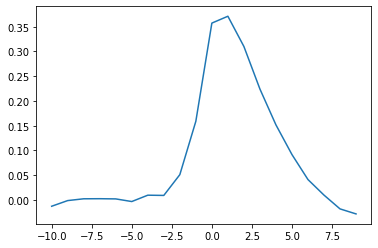

In [10]:
## corr change
plt.plot(lag_range,corr_record)

Pick lag=1.

A is leading by 1.

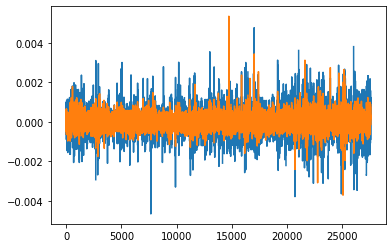

In [11]:
lag=1
plt.plot(df.ret_A.shift(lag))
plt.plot(df.ret_B)

## Q2: predictive model

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

In [13]:
## predict B with leading returns of A
lag=1
y = df.ret_B
X = df.ret_A.shift(lag).to_frame()
idx = np.logical_not(np.logical_or(np.isnan(X.ret_A), np.isnan(y)))
y=y[idx]
X=X[idx]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

regr = LinearRegression()
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)
print('Coefficients: \n', regr.coef_)
print('Mean squared error: %.10f'% mean_squared_error(y_test, y_pred))
print('R2: %.2f'% r2_score(y_test, y_pred))

Coefficients: 
 [0.22347225]
Mean squared error: 0.0000000754
R2: 0.12


Also it's worth trying multi-regression of ret_B against ret_A with lag 1, 2, 3.